In [5]:
# pip install PyPortfolioOpt

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [7]:
#%% extract data
start_date = '2024-01-01'
split_date = '2024-06-30'
end_date = '2024-07-31'
tickers = ['AAPL','MSFT','NVDA','GOOG','AMZN','META','TSM','LLY','TSLA','AVGO']

train = yf.download(tickers, start=start_date, end=split_date)['Close']
test = yf.download(tickers, start=split_date, end=end_date)['Close']
test_ret = test.pct_change()

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed


In [8]:
# calculate expected returns and covariance matrix
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(train)
S = CovarianceShrinkage(train).ledoit_wolf()

In [9]:
# calculate weights of efficient portfolio
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
weights = ef.clean_weights()
print(weights)

OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('AVGO', 0.0), ('GOOG', 0.04042), ('LLY', 0.19398), ('META', 0.0), ('MSFT', 0.0), ('NVDA', 0.76559), ('TSLA', 0.0), ('TSM', 0.0)])


In [10]:
# using these weights to indicate how many shares of each asset to buy, assuming portfolio of $1,000,000
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(train)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=1000000)
allocation, leftover = da.lp_portfolio()
print(allocation)

{'GOOG': 221, 'LLY': 214, 'NVDA': 6197}


In [13]:
def rough_weight_ret(data, weights):
    # Make a copy of the original data
    data_copy = data.copy()

    # calculate returns of test portfolio, using rough weights
    for ticker, weight in weights.items():
        if ticker in data_copy.columns:
            data_copy[ticker] = data_copy[ticker] * weight

    data_copy['trade'] = data_copy.sum(axis=1)
    data_copy['return'] = data.sum(axis=1)/10
    
    # convert to log returns
    data_copy['trade'] = np.log( 1 + data_copy['trade'])
    data_copy['return'] = np.log( 1 + data_copy['return'])

    # calculate returns over test period
    annual_ret = np.exp(data_copy['trade'].sum())-1
    print('------using rough weights------')
    print('regular return: ',annual_ret)

    # calculate standard deviation over same period
    annual_std = (np.exp(data_copy['trade'])-1).std()
    print('regular std: ', annual_std)

    # calculate sharpe ratio
    sr = annual_ret/ annual_std
    print("Sharpe Ratio is: ", sr)
    print('--------------------------------')
    
    data_copy.to_csv('C:\\Users\\E1124957\\Dropbox\\NUS\\DSA5205\\project\\MVO\\MVO.csv')
    data_copy[["return","trade"]].cumsum().plot(figsize=(10,3))

------using rough weights------
regular return:  -0.11243958649928998
regular std:  0.026371767874025825
Sharpe Ratio is:  -4.263634771714883
--------------------------------


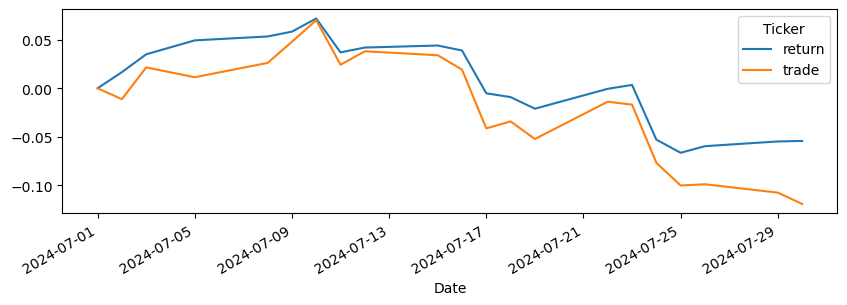

In [14]:
rough_weight_ret(test_ret, weights)
#discrete_ret(test, allocation)